In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import pydot
import pydotplus
import graphviz

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


# Importing Dataset

In [2]:
from zipfile import ZipFile
 
data_path = '/Users/bpratyush/Downloads/lung-and-colon-cancer-histopathological-images.zip'
 
with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


# Data Visualisation

In [3]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

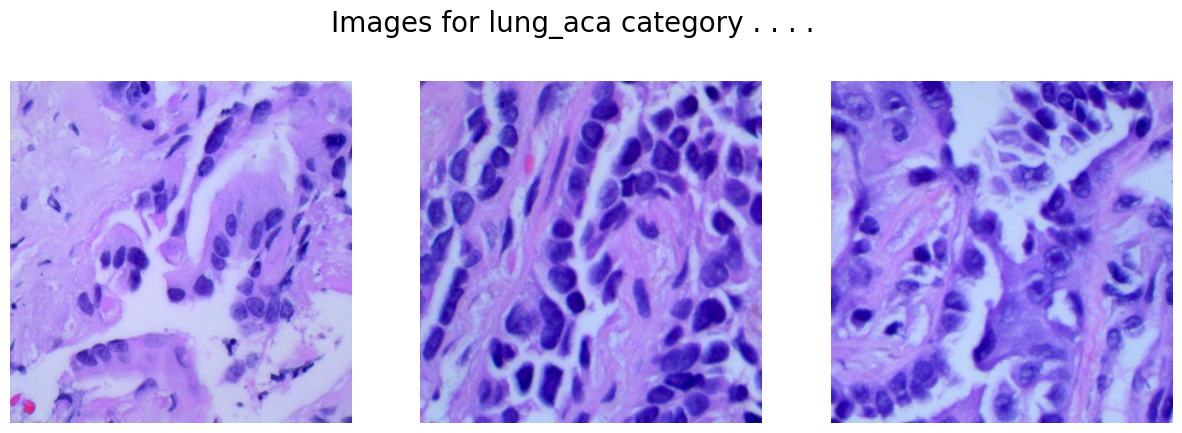

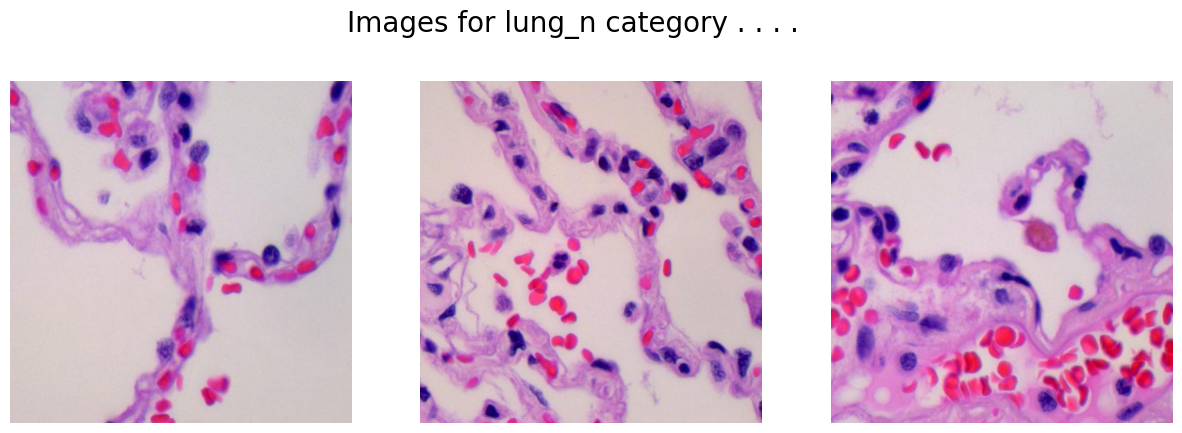

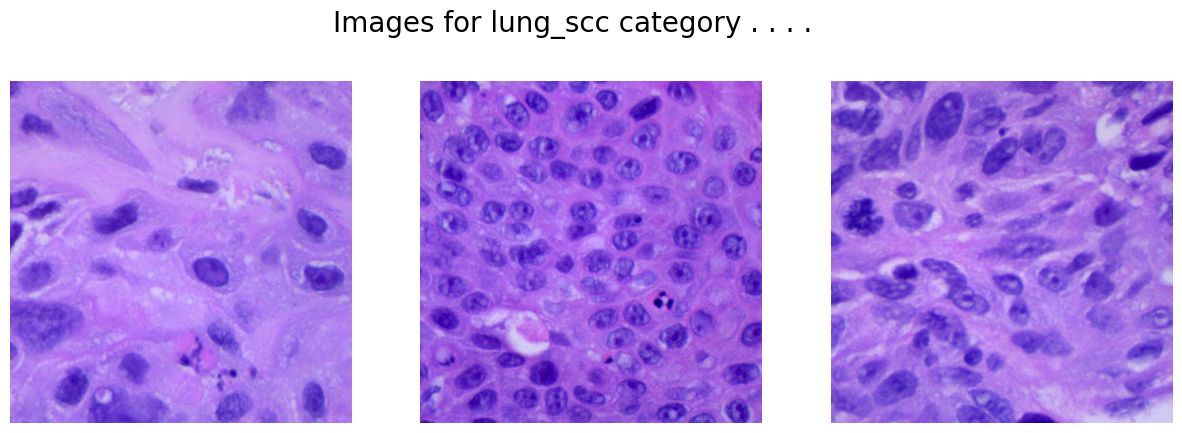

In [4]:
path = '/Users/bpratyush/Downloads/lung_colon_image_set/lung_image_sets'

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

# Data Preparation - Training Dataset

In [5]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64


In [7]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')
    for image in images:
        img = cv2.imread(image)
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)


X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values


In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,test_size = SPLIT,random_state = 42)
print(X_train.shape, X_val.shape)


(12000, 256, 256, 3) (3000, 256, 256, 3)


# CNN Model Development

In [9]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                kernel_size=(5, 5),
                activation='relu',
                input_shape=(IMG_SIZE, IMG_SIZE, 3),
                padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=64,
                kernel_size=(3, 3),
                activation='relu',
                padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=128,
                kernel_size=(3, 3),
                activation='relu',
                padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])


In [10]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0

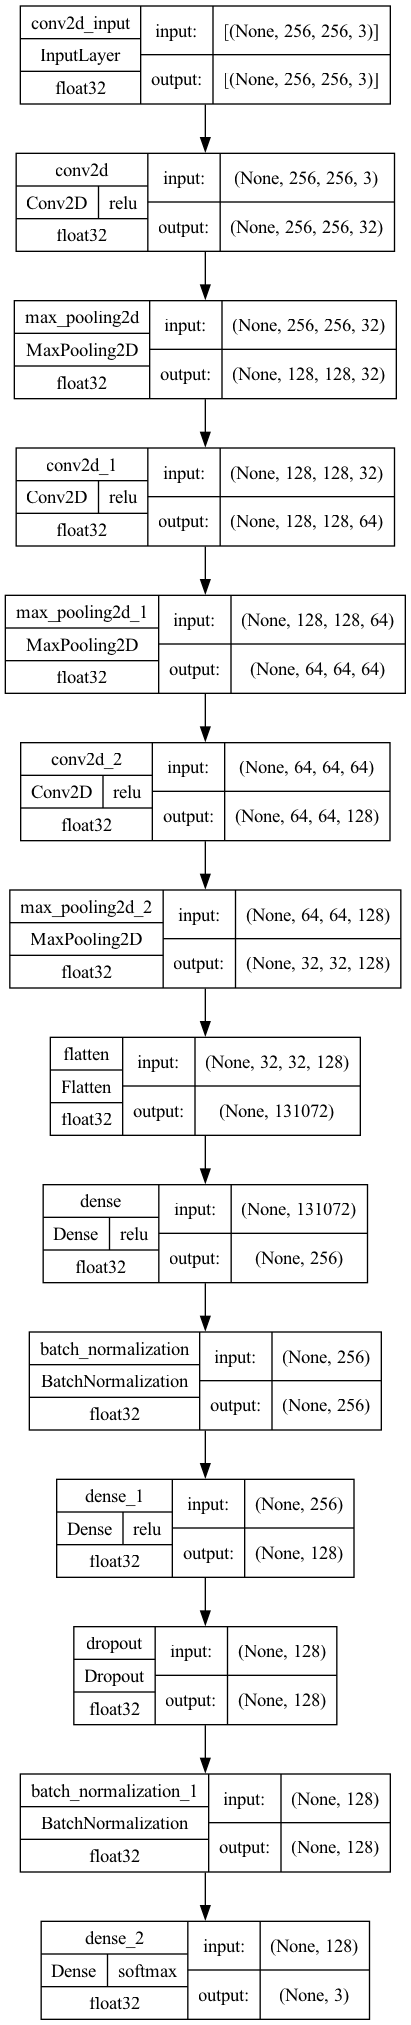

In [11]:
keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)


In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)



In [14]:
history = model.fit(X_train, Y_train, epochs=EPOCHS, validation_data=(X_val, Y_val))

Epoch 1/10
375/375 [==============================] - 402s 1s/step - loss: 0.3955 - accuracy: 0.8363 - val_loss: 6.6025 - val_accuracy: 0.6500
Epoch 2/10
375/375 [==============================] - 365s 974ms/step - loss: 0.2741 - accuracy: 0.8882 - val_loss: 0.7938 - val_accuracy: 0.6773
Epoch 3/10
375/375 [==============================] - 347s 924ms/step - loss: 0.2301 - accuracy: 0.9093 - val_loss: 4.4381 - val_accuracy: 0.3750
Epoch 4/10
375/375 [==============================] - 323s 861ms/step - loss: 0.1851 - accuracy: 0.9273 - val_loss: 0.3792 - val_accuracy: 0.8577
Epoch 5/10
375/375 [==============================] - 326s 870ms/step - loss: 0.1523 - accuracy: 0.9408 - val_loss: 4.5227 - val_accuracy: 0.4337
Epoch 6/10
375/375 [==============================] - 306s 815ms/step - loss: 0.1294 - accuracy: 0.9508 - val_loss: 3.0946 - val_accuracy: 0.6703
Epoch 7/10
375/375 [==============================] - 303s 808ms/step - loss: 0.1226 - accuracy: 0.9536 - val_loss: 2.6617 - va

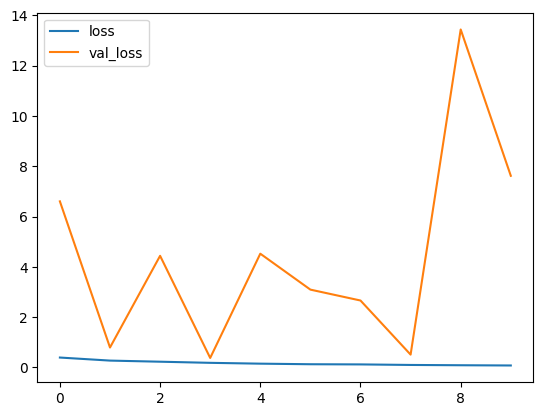

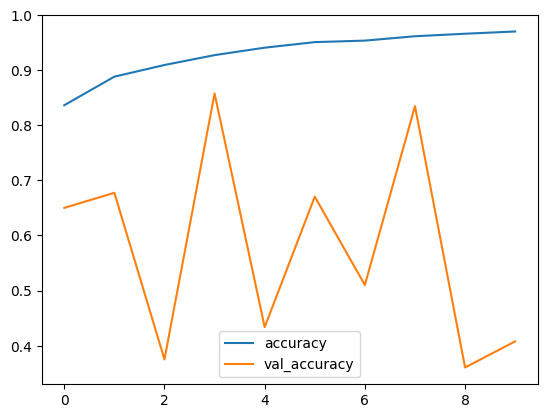

In [15]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


# Model Evaluation - Testing Dataset

In [16]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


94/94 [==============================] - 20s 210ms/step


In [17]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[ 88,   0, 949],
       [145, 145, 680],
       [  3,   0, 990]])

In [18]:
print(metrics.classification_report(Y_val, Y_pred,target_names=classes))


              precision    recall  f1-score   support

    lung_aca       0.37      0.08      0.14      1037
      lung_n       1.00      0.15      0.26       970
    lung_scc       0.38      1.00      0.55       993

    accuracy                           0.41      3000
   macro avg       0.58      0.41      0.32      3000
weighted avg       0.58      0.41      0.31      3000

